In [1]:
!python --version
!nvcc --version
!pip list

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Package                          Version
-------------------------------- ------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
auto

In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

C:\Users\EaglesonLabs\Anaconda2\envs\vit-object-detection\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import os
full_data_path = "Aero - yolov8/train"
image_path = os.path.join(full_data_path, 'images')
label_path = os.path.join(full_data_path, 'labels')
image_size = 400  # resize input images to this size
num_classes = 2 # the number of classes in the dataset
    
def list_files():
    files = []
    freqs = {}
    zero_objects = 0
    print('curr_path:', full_data_path)
    for r, d, f in os.walk(label_path):
        for file in f:
            if file.endswith('.txt'):
                with open(os.path.join(label_path, file), 'r') as fp: 
                    lines = fp.readlines()
                    boxes = len(lines)
                    freqs[boxes] = freqs.get(boxes, 0) + 1
                files.append(file[:-4])  # Append the file without the extension

    return files, freqs

files, freqs = list_files()
print(freqs)

curr_path: Aero - yolov8/train
{3: 85, 2: 127, 1: 351, 0: 284, 4: 2}


In [5]:
from keras.utils import to_categorical

def read_yolo_annotation_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    annotations = []
    for line in lines:
        parts = line.strip().split(' ')
        parts[0] = int(parts[0])
        parts[1], parts[2], parts[3], parts[4] = map(float, parts[1:])
        annotations.append(parts)

    return annotations

In [6]:
images, all_annotations = [], []

# loop over the annotations and images, preprocess them and store in lists
for file in files:
    # load the x,y,w,h of the bounding box here as top_left_x/y & bottom_right_x/y
    annotations = read_yolo_annotation_file(label_path + '/' + file + '.txt')
    
    # load the actual image here
    image = keras.utils.load_img(image_path + "/" + file + '.jpg',)
    image = image.resize((image_size, image_size))
    
    # appends annotations to the list
    for annotation in annotations:
        all_annotations.append(annotation)
    
    # appends images to the list
    for _ in range(len(annotations)):
        # convert image to array and append to 
        images.append(keras.utils.img_to_array(image))

print('files:', len(files))
print('images:', len(images))
print('annotations:', len(all_annotations))

# Convert the list to numpy array, split to train and test dataset
x_train = images[:int(0.8 * len(images))]
x_test = images[int(0.8 * len(images)):]

# Convert the list of annotations to a list of numpy arrays
y_train = all_annotations[:int(0.8 * len(all_annotations))]
y_test = all_annotations[int(0.8 * len(all_annotations)):]

print('y_train', len(y_train))
print('y_test', len(y_test))
print('x_train', len(x_train))
print('x_test', len(x_test))



files: 849
images: 868
annotations: 868
y_train 694
y_test 174
x_train 694
x_test 174


In [7]:
print(y_train[0])

[1, 0.42196354166666666, 0.11139814814814815, 0.021255208333333334, 0.019435185185185184]


[1, 0.42196354166666666, 0.11139814814814815, 0.021255208333333334, 0.019435185185185184]
bounding_box:  [0.42196354166666666, 0.11139814814814815, 0.021255208333333334, 0.019435185185185184]
label:  1
bounding_box:  [0.42196354166666666, 0.11139814814814815, 0.021255208333333334, 0.019435185185185184]
label:  1
bounding_box:  [0.42196354166666666, 0.11139814814814815, 0.021255208333333334, 0.019435185185185184]
label:  1
bounding_box:  [0.42196354166666666, 0.11139814814814815, 0.021255208333333334, 0.019435185185185184]
label:  1
bounding_box:  [0.42196354166666666, 0.11139814814814815, 0.021255208333333334, 0.019435185185185184]
label:  1


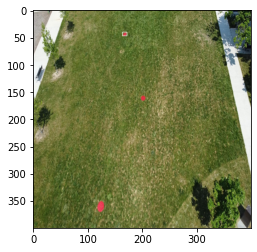

In [8]:
num = 0

image = x_train[num].astype("uint8")
annotations = y_train[num]
num_objects = len(annotations)
print(annotations)
for obj in range(num_objects):
    bounding_box = annotations[1:]
    label = annotations[0]
    print('bounding_box: ', bounding_box)
    print('label: ', label)

    x_center, y_center = bounding_box[0] * image_size,  bounding_box[1] * image_size
    width, height = bounding_box[2] * image_size,  bounding_box[3] * image_size

    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min = int(x_center - (width / 2))
    y_min = int( y_center - (height / 2))
    x_max = x_min + int(width)
    y_max = y_min + int(height)

    top_left = (x_min, y_min)
    bottom_right = (x_max, y_max)

    # Convert image to RGB if it's grayscale
    image = np.squeeze(image)  # Remove the extra batch dimension
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw rectangles
    cv2.rectangle(image, top_left, bottom_right, (255,255,255), 1)
plt.imshow(image)
plt.show()

In [9]:
architecture_id = 'Yolov8 format - reduced patch'

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

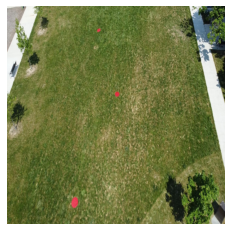

Image size: 400 X 400
Patch size: 100 X 100
16 patches per image 
30000 elements per patch


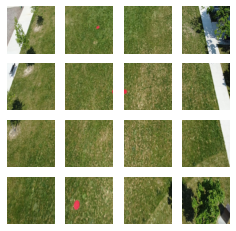

In [12]:
import matplotlib.pyplot as plt

patch_size = 100  # Size of the patches to be extracted from the input images

# Convert the EagerTensor to a NumPy array
x_train_numpy = x_train[0].astype("uint8")

plt.figure(figsize=(4, 4))
plt.imshow(x_train_numpy)
plt.axis("off")
plt.show()

patches = Patches(patch_size)(tf.convert_to_tensor([x_train_numpy]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [15]:
def calculate_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / union

In [16]:
folder_count = 0  # type: int
input_path = "vit-model performance"  # type: str
for folders in os.listdir(input_path):  # loop over all files
    if os.path.isdir(os.path.join(input_path, folders)):  # if it's a directory
        folder_count += 1  # increment counter
new_folder = os.path.join(input_path, 'model '+ str(folder_count) + ' - ' + architecture_id)
os.mkdir(new_folder)

In [17]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    # Train the model using both bounding_boxes_y and class_labels_y as y-values.
    history = model.fit(
        x = x_train,    # Your training image data
        y = {'bounding_box': bounding_boxes_y_train, 'class_predictions': class_labels_y_train},
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=30),
        ],
    )
    
    dot_img_file = os.path.join(new_folder, 'architecture.png')
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    display(Image(dot_img_file))
    return history, model


class_labels_y_train =  np.array([arr[0] for arr in y_train])
bounding_boxes_y_train = np.array([arr[1:] for arr in y_train])
class_labels_y_test = np.array([arr[0] for arr in y_test])
bounding_boxes_y_test = np.array([arr[1:] for arr in y_test])

class_labels_y_train = tf.one_hot(class_labels_y_train, num_classes)
class_labels_y_test = tf.one_hot(class_labels_y_test, num_classes)

# Now you can directly convert the numpy arrays to TensorFlow tensors
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

# Now you can directly convert the numpy arrays to TensorFlow tensors
class_labels_y_train = tf.convert_to_tensor(class_labels_y_train)
bounding_boxes_y_train = tf.convert_to_tensor(bounding_boxes_y_train)
class_labels_y_test = tf.convert_to_tensor(class_labels_y_test)
bounding_boxes_y_test = tf.convert_to_tensor(bounding_boxes_y_test)




In [31]:
#build and train
def build_model(hp):
    input_shape = (image_size, image_size, 3)  # input image shape
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 32
    num_epochs = 100
    projection_dim = 8
    num_heads = 4
    # Size of the transformer layers
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]

    transformer_layers = 4
    mlp_head_units = [512, 64, 32]  # Size of the dense layers

    num_patches = (image_size // patch_size) ** 2

    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    
    
    # Add MLP.
    #features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    
    for i in range(1, hp.Int("num_layers", 2, 6)):
        representation = layers.Dense(units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),activation="relu")(representation)
        representation = layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1))(representation)
        
    # Final MLP head for bounding box prediction
    bounding_box = layers.Dense(4, name='bounding_box')(representation)

    # Final dense layer for class prediction
    class_predictions = layers.Dense(num_classes, activation='softmax', name='class_predictions')(representation)

    # Keras model with both bounding box and class predictions
    model = keras.Model(inputs=inputs, outputs=[bounding_box, class_predictions])
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    # Compile the model with appropriate loss functions
    model.compile(
        optimizer='adam',
        loss={'bounding_box': 'mse', 'class_predictions': 'binary_crossentropy'},
        metrics = {'class_predictions' : 'accuracy', 'bounding_box' : calculate_iou }
    )
    
    return model

# model = build_model()
# # Train model
# history = []
# history, model = run_experiment(
#     vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
# )

In [32]:
!pip install keras-tuner

In [40]:
import keras_tuner as kt
# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("class_predictions_accuracy", direction="max"),
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=1,
                     directory="kt_dir",
                     project_name="kt_hyperband",
                     overwrite=True)
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [41]:
tuner.search(x_train,
             y = {'bounding_box': bounding_boxes_y_train, 'class_predictions': class_labels_y_train},
             epochs=5
            )
            

Trial 30 Complete [00h 00m 26s]
class_predictions_accuracy: 0.7219020128250122

Best class_predictions_accuracy So Far: 0.7247838377952576
Total elapsed time: 00h 06m 41s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_model =  tuner.get_best_models()[0]

In [47]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'num_layers': 2, 'units_1': 64, 'dropout_1': 0.1, 'units_2': 320, 'dropout_2': 0.0, 'units_3': 384, 'dropout_3': 0.0, 'units_4': 288, 'dropout_4': 0.0, 'units_5': 416, 'dropout_5': 0.1, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0008'}


In [ ]:
plt.plot(history.history['class_predictions_accuracy'])
plt.plot(history.history['val_class_predictions_accuracy'])
plt.title('Prediction Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'class predictions accuracy.png')
plt.savefig(model_file)
plt.show()

In [ ]:
plt.plot(history.history['bounding_box_loss'])
plt.plot(history.history['val_bounding_box_loss'])
plt.title('Bounding Box Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'bounding box mean squared error.png')
plt.savefig(model_file)
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss during Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'loss.png')
plt.savefig(model_file,dpi=600, facecolor='w')
plt.show()

In [ ]:
plt.plot(history.history['bounding_box_calculate_iou'])
plt.plot(history.history['val_bounding_box_calculate_iou'])
plt.title('Intersection over Union during Training')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'IoU.png')
plt.savefig(model_file,dpi=600, facecolor='w')
plt.show()


In [ ]:
from IPython.display import display
from PIL import Image

missed = 0

for i in range(0, len(x_test)):
    image = x_test[i].numpy().astype("uint8")
    # Add an additional dimension for batch size
    image = np.expand_dims(image, axis=0)
    x_center_actual = bounding_boxes_y_test[i][0] * image_size
    y_center_actual = bounding_boxes_y_test[i][1] * image_size
    width_actual = bounding_boxes_y_test[i][2] * image_size
    height_actual = bounding_boxes_y_test[i][3] * image_size

    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min_actual = int(x_center_actual - (width_actual / 2))
    y_min_actual = int( y_center_actual - (height_actual / 2))
    x_max_actual = x_min_actual + int(width_actual)
    y_max_actual = y_min_actual + int(height_actual)

    top_left_actual = (x_min_actual, y_min_actual)
    bottom_right_actual = (x_max_actual, y_max_actual)

    predictions = model(image)


    # Extract the bounding box center coordinates from predictions
    predicted_box_coords = predictions[0].numpy()[0]
    x_center, y_center = predicted_box_coords[0] * image_size,  predicted_box_coords[1] * image_size
    width, height = predicted_box_coords[2] * image_size,  predicted_box_coords[3] * image_size

    #Extract the prediction label
    predicted_labels = predictions[1].numpy()[0]
    #print('predicted_labels: ', predicted_labels)
    predicted_label =  np.argmax(predicted_labels)
    actual_label =  np.argmax(class_labels_y_test[i].numpy())
    
    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min = int(x_center - (width / 2))
    y_min = int( y_center - (height / 2))
    x_max = x_min + int(width)
    y_max = y_min + int(height)

    top_left = (x_min, y_min)
    bottom_right = (x_max, y_max)

    # Convert image to RGB if it's grayscale
    image = np.squeeze(image)  # Remove the extra batch dimension
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Now use the tuple coordinates in the cv2.rectangle function
    color = (0, 255, 0)  # Set green for actual
    # Draw rectangles
    image = cv2.rectangle(image, top_left_actual, bottom_right_actual, color, 2)
    color = (255, 0, 0)  # Set red for prediction
    # Draw rectangles
    cv2.rectangle(image, top_left, bottom_right, color, 2)
    
    #only print the cases where the labels disagreed
    if actual_label == predicted_label:
        missed += 1
        print('predicted_box_coords: ', predicted_box_coords)
        print('actual_box_coords', bounding_boxes_y_test[i].numpy())
        print('predicted_label: ', predicted_label)
        print('actual_label: ', actual_label)
        # Convert the numpy array to a PIL Image
        image_pil = Image.fromarray(image)
        # Display the image and make it persist
        display(image_pil)

In [ ]:
print(missed)